In [1]:
from gym import Env
import gymnasium as gym
from gymnasium import spaces
from gym.spaces import Discrete, Box
import numpy as np
import random
import pygame
from gymnasium import spaces
from gym.spaces import Discrete, Box
import numpy as np
import pygame
from copy import copy
import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete
from pettingzoo import ParallelEnv
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

Environment

In [2]:
class TrainEnv(Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, visualize=False):
        # Actions: accelerate, slow down, maintain speed
        self.action_space = Discrete(3)

        # Leader: [velocity, position]
        # Leader starts at a random location between 50 and 100 units from the agent
        x = np.random.uniform(150, 200)
        self.leader = [0.25, x]

        # Observations
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0, 0.0]), high=np.array([1000.0, 1.0, 1.0, 1.0]))
        # Initial state: [distance to leader, velocity, leader's velocity, relative speed]
        # Agent starts at x = 100
        self.state = [x - 100, 0.0, 0.25, 0.25]
        self.target = np.array([900, 150])
        self.inrange = False

        # Constants
        self.max_speed = 1.0  # Maximum speed
        self.max_acceleration = 0.005  # Maximum speed increase per step
        self.max_deceleration = 0.005  # Maximum speed decrease per step
        self.relative_braking_distance = 50
        self.max_deviation = 10

        if visualize:
            # Initialize variables for Pygame
            self.screen = None
            self.clock = None
            self.is_pygame_initialized = False  # Flag to check if Pygame is initialized

            self.init_pygame()

    def init_pygame(self):
        print("Initializing Pygame...")
        pygame.init() 
        self.screen = pygame.display.set_mode((1000, 300))
        self.clock = pygame.time.Clock()
        self.is_pygame_initialized = True

        # Initialize font
        pygame.font.init()
        self.font = pygame.font.Font(None, 36)

    def move_leader(self):
        # Leader's current speed
        leader_speed = self.leader[0]
        
        # Action: 0 = accelerate, 1 = decelerate, 2 = maintain speed
        leader_action = np.random.choice([0, 1, 2])
        
        if leader_action == 0:  # Accelerate
            leader_speed = min(self.max_speed, leader_speed + self.max_acceleration)
        elif leader_action == 1:  # Decelerate
            leader_speed = max(0.5, leader_speed - self.max_deceleration)  # Minimum speed = 0.5
        # Maintain speed requires no change

        # Update leader's speed and position
        self.leader[0] = leader_speed
        self.leader[1] += leader_speed  # Update the leader's position by its current speed

        # Update state
        self.state[0] = self.state[0] + leader_speed
        # self.state[1] stays the same
        self.state[2] = leader_speed
        self.state[3] = abs(leader_speed - self.state[1])       


    def step(self, action):

        reward = 0
        distance_to_leader, speed, leaders_speed, _ = self.state

        # Action: 0 = accelerate, 1 = decelerate, 2 = maintain speed
        if action == 0:  # Accelerate
            speed = min(self.max_speed, speed + self.max_acceleration)
        elif action == 1:  # Decelerate
            speed = max(0.0, speed - self.max_deceleration)
        # Maintain speed requires no change

        # Update state
        self.state[0] = distance_to_leader - speed
        self.state[1] = speed
        # self.state[2] stays the same
        self.state[3] = abs(leaders_speed - speed)

        # Rewards
        # Calculate distance gap and reward accordingly
        dist_gap = abs(self.state[0] - self.relative_braking_distance)
        reward = -dist_gap  # Penalize based on how far the agent is from the desired distance

        if self.state[0] <= 5:
            reward -= 1000  # Collision penalty
            done = True
        else:
            done = False

        if abs(self.leader[1] - 900) <= 5: # end of episode
            done = True  

        # Move the leader after the agent's action
        if not done:
            self.move_leader()        
        return self.state, reward, done, {}

    def reset(self):
        x = np.random.uniform(125, 200)
        self.leader = [0.25, x]
        self.state = [x - 100, 0.0, 0.25, 0.25]
        return self.state

    def render(self, mode='human'):
        # Clear the screen
        self.screen.fill((0, 0, 0))

        # Draw the target
        pygame.draw.circle(self.screen, (255, 0, 0), (int(self.target[0]), int(self.target[1])), 10)

        # Draw leader
        pygame.draw.circle(self.screen, (0, 255, 0), (int(self.leader[1]), 150), 10)

        # Draw the train (as a small circle)
        train_position = (int(self.leader[1] - self.state[0]), 150)
        pygame.draw.circle(self.screen, (0, 255, 0), train_position, 10)

        speed_text = self.font.render(f"Relative Speed: {np.round(self.state[3], 3)} - Distance to leader: {np.round(self.state[0], 3)} - In Range: {str(self.inrange)}", True, (255, 255, 255))
        # Blit the text onto the screen
        self.screen.blit(speed_text, (10, 10))  

        # Update the display
        pygame.display.flip()

        # Cap the frame rate
        self.clock.tick(60)

    def close(self):
        if self.is_pygame_initialized:
            print("Closing Pygame...")
            pygame.quit()
            self.is_pygame_initialized = False


Model

In [3]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=5e-5):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0 # memory counter

        self.Q_eval = DeepQNetwork(self.lr, input_dims=input_dims, fc1_dims=256, fc2_dims=256, n_actions=n_actions)


        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_cntr += 1


    # explore or exploit
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self):
        # learn as soon as batch size full of memory
        if self.mem_cntr < self.batch_size: # if memory counter smaller than batch size
            return
        self.Q_eval.optimizer.zero_grad()
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        action_batch = self.action_memory[batch]
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
            else self.eps_min
        
        #print(f"Epsilon: {self.epsilon}")

    # Save model weights
    def save_model(self, filepath):
        T.save(self.Q_eval.state_dict(), filepath)

    # Load model weights
    def load_model(self, filepath):
        self.Q_eval.load_state_dict(T.load(filepath))


Run only for training

In [5]:
# Initialize the environment
env = TrainEnv(True)

# Initialize the agent (same model for all agents)
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=3, eps_end=0.01, input_dims=[4], lr=0.001)

# Variables to track performance
rewards, eps_history = [], []
n_games = 100  # Number of training episodes

# Loop over episodes
for i in range(n_games):
    total_reward = 0
    done = False
    observations = env.reset() 

    # Game loop for each episode
    while not done:  

        for event in pygame.event.get():
            if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE):
                print("Quitting Pygame...")
                env.close()  # Ensure Pygame is closed properly
                done = True
                break
        
        action = agent.choose_action(observations)
        new_observations, reward, done, info = env.step(action)
        agent.store_transition(observations, action, reward, new_observations, done)
        agent.learn()

        total_reward += reward
        observations = new_observations

        env.render()


    # Store the score for this episode
    rewards.append(total_reward)
    eps_history.append(i)
    print(f'Episode {i} | Reward: {total_reward:.2f}')

agent.save_model('dqn_weights_platooning.pth')


c:\Users\benat\anaconda3\Lib\site-packages\gym\spaces\box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Initializing Pygame...
Episode 0 | Reward: -475131.50
Episode 1 | Reward: -475207.92
Episode 2 | Reward: -402341.65
Episode 3 | Reward: -481737.14
Episode 4 | Reward: -374809.85
Episode 5 | Reward: -466830.69
Episode 6 | Reward: -444798.29
Episode 7 | Reward: -414990.88
Episode 8 | Reward: -422686.00
Episode 9 | Reward: -483622.13
Episode 10 | Reward: -449429.97
Episode 11 | Reward: -459840.56
Episode 12 | Reward: -487982.92
Episode 13 | Reward: -502986.37
Episode 14 | Reward: -408794.31
Episode 15 | Reward: -506749.24
Episode 16 | Reward: -491906.38
Episode 17 | Reward: -462641.03
Episode 18 | Reward: -451545.10
Episode 19 | Reward: -421532.51
Episode 20 | Reward: -447976.41
Episode 21 | Reward: -493151.24
Episode 22 | Reward: -373302.28
Episode 23 | Reward: -483643.50
Episode 24 | Reward: -487817.19
Episode 25 | Reward: -485059.74
Episode 26 | Reward: -483359.21
Episode 27 | Reward: -441103.41
Quitting Pygame...
Closing Pygame...


error: display Surface quit

Render and Visualization

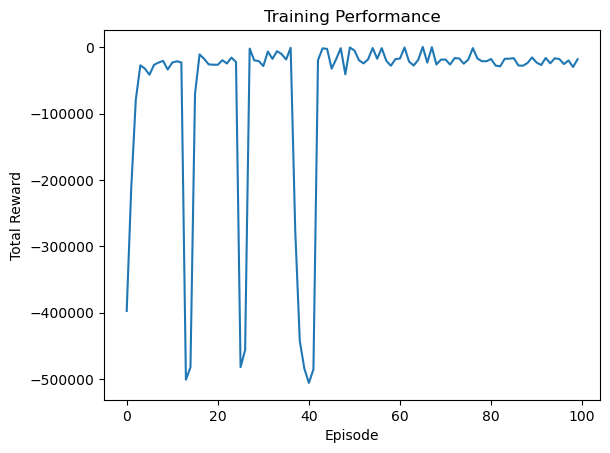

In [7]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.show()